# BBC News Classification
### News Articles Categorization

2023.11.26 Daisaku Ikoma

## Description
We performed classification of BBC news articles as an assignment [1] in a previous course, Unsupervised Algorithms in Machine Learning. In this task, we used unsupervised learning to classify article categories and compared it with supervised learning. Supervised learning achieved very good performance, and unsupervised learning achieved sufficient classification performance, although inferior to supervised learning, and learning efficiency superior to supervised learning.

In this project, we would like to investigate how much performance can be improved when deep learning is applied to classifying BBC news articles. The subject of this project is a natural language classification problem, and the ability of BERT [2], which is very famous in this field, will be evaluated as a model for consideration.

The problem of classifying BBC news articles is discussed below. We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech. The goal will be to build a system that can accurately classify previously unseen news articles into the right category. The competition is evaluated using Accuracy as a metric.

#### Dataset Description
The dataset is briefly explained below. File descriptions;
- BBC News Train.csv - the training set of 1490 records
- BBC News Test.csv - the test set of 736 records
- BBC News Sample Solution.csv - a sample submission file in the correct format

Data fields;
- ArticleId - Article id unique # given to the record
- Article - text of the header and article
- Category - cateogry of the article (tech, business, sport, entertainment, politics/li>

#### Import libraries and read data

In [2]:
# import libraries
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import BertTokenizer, AutoTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification, AutoModel, AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TextClassificationPipeline

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# read csv data
train_data = pd.read_csv('../input/learn-ai-bbc/BBC News Train.csv')
test_data = pd.read_csv('../input/learn-ai-bbc/BBC News Test.csv')
sample_solution_data = pd.read_csv('../input/learn-ai-bbc/BBC News Sample Solution.csv')

We will check the basic items of each data set.

In [4]:
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [6]:
sample_solution_data.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [9]:
sample_solution_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


We were able to confirm that there is no null data.

## Extracting word features and Exploratory Data Analysis (EDA)

There is no null data and the datatypes are appropriate, so no action is required on these. First, check the histogram for each category and consider applying over/under sampling techniques if necessary. Then proceed to processing raw texts to feature vectors.

#### Histogram of Category

In [10]:
# Check the unique labels 
uniq_cat = train_data['Category'].unique()
print(uniq_cat)

['business' 'tech' 'politics' 'sport' 'entertainment']


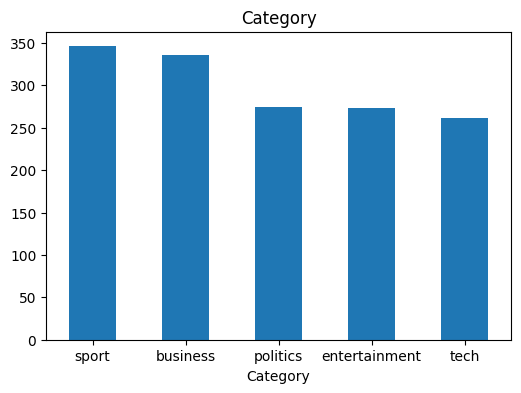

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
train_data.Category.value_counts().plot.bar(ax=ax, title="Category");
ax.tick_params(axis='x', rotation=0)
plt.show()

The frequencies of the five categories are generally uniform, and we judge that over/under sampling is not necessary.

#### Histogram of Word counts

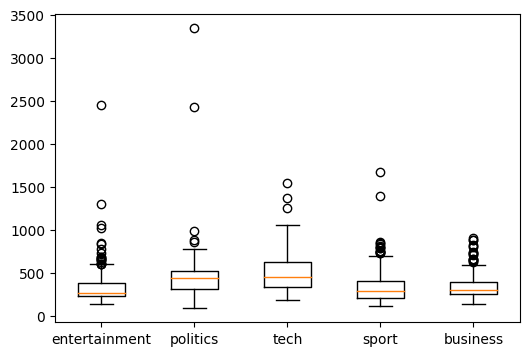

In [12]:
train_data["WordCount"] = train_data.Text.apply(lambda x: len(x.split()))
counts = []
categories = list(set(train_data.Category))
for cat in categories:
    counts.append(train_data[train_data.Category == cat].WordCount.to_numpy())
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.boxplot(counts);
ax.set_xticks(range(1, len(categories)+1), categories);

For example, in politics and entertainment, sentences with an outlier number of characters can be found here and there. The number of letters in a sentence can affect analysis and should be taken into account when interpreting analysis results. In some cases, we may need a way to compensate for variations in sentence length.

#### Extracting word features: TF-IDF [3]

Apply TF-IDF, which is very commonly used in processing raw texts to feature vectors. TF-IDF is one of the statistical measures that express "how important each term is in the document". Specifically, the TF (Term Frequency) value that expresses "how often" a "certain word" appears "in a certain document" and "how often a document containing a certain word" appears "in all documents" It is a value obtained by multiplying the IDF (Inverse Document Frequency) value, which indicates whether a document exists at a low frequency. Definitions are given below.

Term Frequency ($tf$) is the relative frequency of term $t$ in document $d$.

$$
tf(t, d) = \frac{f_{t,d}}{\sum_{t'}f_{t',d}}
$$

$f_{t,d}$ is the raw count of the word in the document. That is, it means how many times word $t$ appears in document $d$. Simply use the number of words in document $d$ as the denominator.

The inverse document frequency ($idf$) is a measure of how informative the word is.

$$
idf(t, D) = \log{\frac{N}{1+n_{t}}}+1
$$

Where $N$ is the total number of documents in the corpus $N=|D|$, $n_{t}=|{d \in D:t \in d}|$ is the number of documents in which word $t$ appears.

Here, TF-IDF is calculated as follows.

$$
tfidf(t,d,D)=tf(t,d) \cdot idf(t,D)
$$

Now, let's actually apply TF-IDF to BBC News text data.

In [13]:
# processing raw texts to feature vectors using TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', lowercase=True)
tfidf_features = tfidf.fit_transform(np.concatenate((train_data.Text, test_data.Text), axis=0))
train_features = tfidf_features[:1490, :]
test_features = tfidf_features[1490:, :]
print("train data: ", train_features.shape, "\n test data: ", test_features.shape)

train data:  (1490, 14415) 
 test data:  (735, 14415)


In each category, words with high TF-IDF values are identified and validated.

In [14]:
cat_id_df = pd.DataFrame(zip(uniq_cat, list(range(5))), columns=['Category', 'cat_id'])
cat2id = dict(cat_id_df.values)
id2cat = dict(cat_id_df[['cat_id', 'Category']].values)
train_data = train_data.merge(cat_id_df, on='Category', how='left')
true_labels = train_data.cat_id

for cat, cat_id in sorted(cat2id.items()):
    chi2_train_features = chi2(train_features, true_labels==cat_id)
    idx = np.argsort(chi2_train_features[0])
    train_f_names = np.array(tfidf.get_feature_names_out())[idx]
    top_f = train_f_names[-5:]
    print(cat, top_f)

business ['msp' 'rule margin' 'sincerely' '30 million' 'president technology']
entertainment ['wants play' 'rule margin' 'digital home' 'said sunday' 'californian']
politics ['end users' 'imprisonment' 'rule margin' 'sincerely' 'wants play']
sport ['edonkey' 'imprisonment' 'president technology' 'company says'
 'rule margin']
tech ['edonkey' 'president technology' 'end users' 'digital home'
 'imprisonment']


It can be seen that for each category, words that characterize the category well are extracted.

#### Low dimensional visualization using t-SNE [4]
Visually check in advance whether vectorization by TF-IDF is effective for category classification. We apply dimensionality reduction techniques (t-SNE, t-Distributed Stochastic Neighbor Embedding) to project the data into a two-dimensional space for visualization.

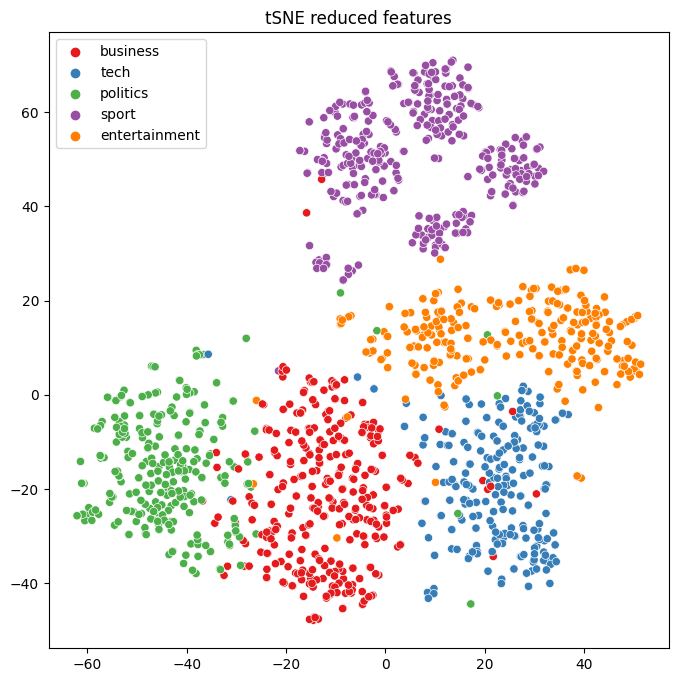

In [15]:
tsne_features = TSNE(n_components=2, random_state=0, init="random").fit_transform(train_features)

category_labels = [id2cat[cat_id] for cat_id in true_labels]
plt.figure(figsize=(8, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=category_labels, palette='Set1')
plt.title('tSNE reduced features')
plt.show()

It can be seen that the data are generally aggregated by category. Using TF-IDF, it is thought that there is potential for accurate classification by unsupervised/supervised learning.

## Unsupervised learning
#### NMF (Non-negative Matrix Factorization)

We will implement unsupervised learning by NMF (Non-negative Matrix Factorization) classification. The input matrix also includes word features from the test dataset. Since some of the words appear in test dataset might not be in the training dataset.

In [16]:
class BBCDocumentNMFClassifier(NMF):
    def __init__(self, n_components=None, init=None, solver='cd', beta_loss='frobenius', 
                 tol=0.0001, max_iter=200, random_state=None, alpha_W=0.0, alpha_H='same', 
                 l1_ratio=0.0, verbose=0, shuffle=False):
        super(BBCDocumentNMFClassifier, self).__init__(n_components=n_components, init=init, solver=solver, beta_loss=beta_loss, 
                 tol=tol, max_iter=max_iter, random_state=random_state, alpha_W=alpha_W, alpha_H=alpha_H, 
                 l1_ratio=l1_ratio, verbose=verbose, shuffle=shuffle)
    
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("y is None.")
        self._y = y
        return super(BBCDocumentNMFClassifier, self).fit(X)
        
    def predict(self, X, test=False):
        if test:
            return np.array([self._mapping[idx] for idx in self.transform(X).argmax(axis=1)])
        y_temp = self.transform(X).argmax(axis=1)
        max_acc, y_pred, = 0, None
        for p in itertools.permutations(range(self._n_components)):
            y_temp_transformed = [p[idx] for idx in y_temp]
            acc = np.mean(self._y==y_temp_transformed)
            if (acc > max_acc):
                max_acc = acc
                y_pred = y_temp_transformed
                self._mapping = p
        return np.array(y_pred)

The accuracy of the train dataset is shown below.

In [17]:
# train dataset accuracy
nmf_clf = BBCDocumentNMFClassifier(n_components=5).fit(train_features, true_labels)
y_train_pred = nmf_clf.predict(train_features)
y_test_pred = nmf_clf.predict(test_features, test=True)
acc_nmf = np.mean(y_train_pred==true_labels)
print('NMF train accuracy:', round(acc_nmf, 4))

NMF train accuracy: 0.947


The accuracy of the train dataset shows a very high accuracy of 0.9477. Next, find the accuracy of the test dataset. Since we do not know the true labels of the test dataset, we calculate the accuracy by submitting it to Kaggle.

In [18]:
# test dataset accuracy
solution_data = pd.DataFrame(data = [], columns = ['ArticleId', 'Category'])
solution_data['ArticleId'] = test_data['ArticleId']
solution_data['Category'] = [id2cat[cat_id] for cat_id in y_test_pred]
solution_data.to_csv('solution_data_3.csv', index=False)

The accuracy of the test dataset is also very good with 0.9592.
#### Hyperparameters optimization
Then change the hyperparameters and record the results.

In [19]:
nmf_param_grid = {"init": ["nndsvdar", "nndsvd"],
                  "solver": ["mu"],
                  "beta_loss": ["kullback-leibler"],
                  "alpha_W" : [0, 1.0],
                  "alpha_H" : [0, 0.5, 1.0],
                  "l1_ratio" : [0, 0.5, 1.0]}
records = {k:list() for k, v in nmf_param_grid.items()}
records["accuracy"] = list()
max_nmf_acc, best_nmf_clf = 0, None
for params in ParameterGrid(nmf_param_grid):
    clf = BBCDocumentNMFClassifier(n_components=5, max_iter=1000, **params).fit(train_features, true_labels)
    for k, v in params.items():
        records[k].append(v)
    y_train_pred = clf.predict(train_features)
    acc = np.mean(true_labels==y_train_pred)
    records["accuracy"].append(acc)
    if (acc > max_nmf_acc):
        max_nmf_acc, best_nmf_clf = acc, clf

max_nmf_acc, best_nmf_clf

(0.9718120805369127,
 BBCDocumentNMFClassifier(alpha_H=1.0, alpha_W=0, beta_loss='kullback-leibler',
                          init='nndsvdar', l1_ratio=0, max_iter=1000,
                          n_components=5, solver='mu'))

The best mode achieves an accuracy of 0.9711. The evaluation results for each model are listed below.

In [20]:
pd.DataFrame(records)

,init,solver,beta_loss,alpha_W,alpha_H,l1_ratio,accuracy
0,nndsvdar,mu,kullback-leibler,0.0,0.0,0.0,0.970470
1,nndsvdar,mu,kullback-leibler,0.0,0.0,0.5,0.970470
2,nndsvdar,mu,kullback-leibler,0.0,0.0,1.0,0.970470
3,nndsvd,mu,kullback-leibler,0.0,0.0,0.0,0.951007
4,nndsvd,mu,kullback-leibler,0.0,0.0,0.5,0.951007
5,nndsvd,mu,kullback-leibler,0.0,0.0,1.0,0.949664
6,nndsvdar,mu,kullback-leibler,1.0,0.0,0.0,0.969799
7,nndsvdar,mu,kullback-leibler,1.0,0.0,0.5,0.971141
8,nndsvdar,mu,kullback-leibler,1.0,0.0,1.0,0.970470
9,nndsvd,mu,kullback-leibler,1.0,0.0,0.0,0.909396


#### Confusion matrix

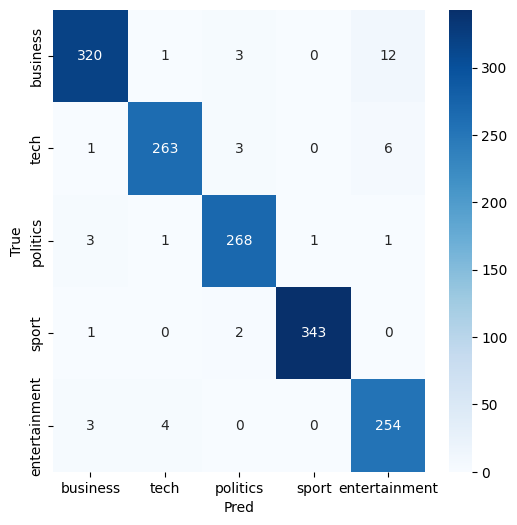

In [21]:
# confusion matrix of the train data with best model
cm = confusion_matrix([id2cat[idx] for idx in true_labels], 
                                      [id2cat[idx] for idx in best_nmf_clf.predict(train_features)])
df_cm = pd.DataFrame(cm, index=uniq_cat, columns=uniq_cat)
plt.figure(figsize=(6, 6))
sns.heatmap(df_cm, annot=True, fmt=',.0f', cmap="Blues")
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

Although predictions were made with good accuracy overall, there were 12 cases of mistakes in predicting business documents as entertainment. 
#### Test dataset accuracy with the best model
Next, find the accuracy of the test dataset of the best model.

In [22]:
# test dataset accuracy with the best model
y_test_pred = best_nmf_clf.predict(test_features, test=True)

solution_data = pd.DataFrame(data = [], columns = ['ArticleId', 'Category'])
solution_data['ArticleId'] = test_data['ArticleId']
solution_data['Category'] = [id2cat[cat_id] for cat_id in y_test_pred]
solution_data.to_csv('solution_data_4.csv', index=False)

The accuracy of the test dataset was also very high at 0.9687. We will consider ways to improve model performance. This time, we used TF-IDF for vectorization of text. In this dataset, it has been confirmed that there is variation in the length of the document by statistical EDA. Therefore, there is an idea to use Okapi BM25, an improved version of VF-IDF, to further reduce the effect of document length.

## Supervised learning

#### SVM (Support Vector Machine)
In the analysis of document data, since the dimensions of features are large, we use SVM that is resistant to large dimensions.

In [23]:
svm_clf = SVC().fit(train_features, true_labels)
y_train_pred = svm_clf.predict(train_features)
acc_svm = np.mean(y_train_pred==true_labels)
acc_svm

1.0

Accuracy on the SVM train dataset is 100% perfect. Next, check the accuracy on the test dataset.

In [24]:
# test dataset accuracy with SVM
y_test_pred = svm_clf.predict(test_features)

solution_data = pd.DataFrame(data = [], columns = ['ArticleId', 'Category'])
solution_data['ArticleId'] = test_data['ArticleId']
solution_data['Category'] = [id2cat[cat_id] for cat_id in y_test_pred]
solution_data.to_csv('solution_data_5.csv', index=False)

SVM has a very good accuracy of 0.9823 on the test dataset. Supervised learning can achieve higher accuracy than unsupervised learning because it can be adjusted to the true labels of the training data.

| train/test | NFM (unsupervised) | SVM (supervised) |
| --- | --- | --- |
| train | 97.18% | 100% |
| test | 96.60% | 98.23% |

Looking at the accuracy of the test dataset, SVM is more accurate than NFM.

## Deep learning

#### BERT (Bidirectional Encoder Representations from Transformers)
In this section, we will finally examine how much performance can be improved with deep learning. The model used is BERT, which is famous for natural language analysis. BERT is a natural language processing model released by Google in 2018. The name BERT is an acronym for "Bidirectional Encoder Representations from Transformers." In 2019, it was adopted in the Google search engine algorithm and became a hot topic. A feature of BERT is its excellent ability to understand context. Its introduction into search engine algorithms has increased the accuracy of understanding search intent from search queries.

First, as usual, split the data into training and validation sets.

In [25]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_data.index.values, train_data.cat_id, test_size=0.1, random_state=42, stratify=train_data.cat_id)

# Specify the data_type (train and val)
train_data['data_type'] = ['not_set'] * train_data.shape[0]
train_data.loc[X_train, 'data_type'] = 'train'
train_data.loc[X_val, 'data_type'] = 'val'
train_data.groupby(['Category', 'cat_id', 'data_type']).count()

ArticleId  Text  WordCount
Category      cat_id data_type                            
business      0      train            302   302        302
                     val               34    34         34
entertainment 4      train            246   246        246
                     val               27    27         27
politics      2      train            247   247        247
                     val               27    27         27
sport         3      train            311   311        311
                     val               35    35         35
tech          1      train            235   235        235
                     val               26    26         26

Next, tokenize the news sentences usin `BertTokenizer` and then, prepare tensor datasets.

In [26]:
# Intiate a bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encode the train dataq
# Truncation is a must scince we know that we have sequences larger than 512
encoded_data_train = tokenizer.batch_encode_plus(train_data[train_data.data_type=='train'].Text.values, 
    add_special_tokens=True, return_attention_mask=True, padding='max_length', truncation = True,
    max_length=512, return_tensors='pt')

encoded_data_val = tokenizer.batch_encode_plus(train_data[train_data.data_type=='val'].Text.values, 
    add_special_tokens=True, return_attention_mask=True, padding='max_length', truncation = True,
    max_length=512, return_tensors='pt')

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data[train_data.data_type=='train'].cat_id.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(train_data[train_data.data_type=='val'].cat_id.values)

In [27]:
# Prepare tensor datasets
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(1341, 149)

We will construct a BERT model. This time, as it is a classification problem, apply `BertForSequenceClassification`.

In [28]:
# instantiate a bert model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = len(categories),
                                                      output_attentions = False, output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# set model and learning paramters
batch_size = 3
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 15
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [30]:
# Seeding all
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In advance, we will define helper functions for evaluation.

In [31]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {id2cat[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [32]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)  
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)      
    return loss_val_avg, predictions, true_vals

#### Traning Loop

In [33]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5104989875858063
Validation loss: 0.14260904798284174
F1 Score (Weighted): 0.9592918726288729


Epoch 2:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.062276582862302594
Validation loss: 0.10055663110222668
F1 Score (Weighted): 0.9734239378434018


Epoch 3:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.02693418324773952
Validation loss: 0.13908212657202967
F1 Score (Weighted): 0.9796987522106942


Epoch 4:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.003963921229788404
Validation loss: 0.17494184028008022
F1 Score (Weighted): 0.9597776145235398


Epoch 5:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0007112078855420469
Validation loss: 0.18430230041209142
F1 Score (Weighted): 0.9661942129234788


Epoch 6:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0005052337060048051
Validation loss: 0.16686774689762388
F1 Score (Weighted): 0.9796987522106942


Epoch 7:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.00038190080331882223
Validation loss: 0.17490672988002187
F1 Score (Weighted): 0.9796987522106942


Epoch 8:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.00030420315942843705
Validation loss: 0.17961771930044051
F1 Score (Weighted): 0.9796987522106942


Epoch 9:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0002502965344279125
Validation loss: 0.18303487097960897
F1 Score (Weighted): 0.9796987522106942


Epoch 10:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.00020973328513356854
Validation loss: 0.18718102264261688
F1 Score (Weighted): 0.9796987522106942


Epoch 11:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.00018152679328809824
Validation loss: 0.1910092171281576
F1 Score (Weighted): 0.9796987522106942


Epoch 12:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.00015776156787958488
Validation loss: 0.19491260167895233
F1 Score (Weighted): 0.9796987522106942


Epoch 13:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.00014170461079190117
Validation loss: 0.19717179142113309
F1 Score (Weighted): 0.9796987522106942


Epoch 14:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.00013086007245435011
Validation loss: 0.19881416156786144
F1 Score (Weighted): 0.9796987522106942


Epoch 15:   0%|          | 0/447 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.000123270285941251
Validation loss: 0.19969579763288492
F1 Score (Weighted): 0.9796987522106942


Now, let's evaluate our model.

In [34]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(uniq_cat),
                                                      output_attentions=False, output_hidden_states=False)
model.to(device)
model.load_state_dict(torch.load('finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))
model.save_pretrained("finetuned_bbc_news_model")
tokenizer.save_pretrained("finetuned_bbc_news_model_tokenizer")
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class: business
Accuracy: 34/34

Class: tech
Accuracy: 23/26

Class: politics
Accuracy: 25/27

Class: sport
Accuracy: 35/35

Class: entertainment
Accuracy: 27/27



In [35]:
accuracy = accuracy_score(true_vals, predictions.argmax(axis=1))
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 96.64%


#### Confusion Matrix

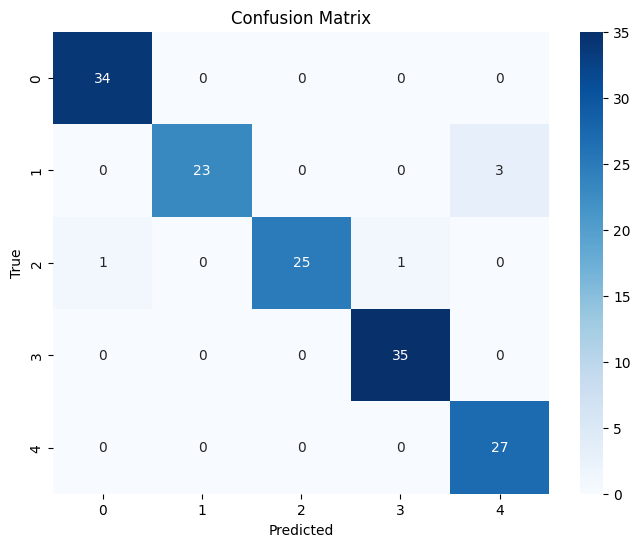

In [36]:
# confusion matrix of the train data with the bert model
conf_matrix = confusion_matrix(true_vals, predictions.argmax(axis=1))
categories = range(len(uniq_cat))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Now, lets create a pipeline for prediction on test data

In [37]:
model = AutoModelForSequenceClassification.from_pretrained('./finetuned_bbc_news_model')
tokenizer = AutoTokenizer.from_pretrained('./finetuned_bbc_news_model_tokenizer', return_tensors = 'pt')
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, framework='pt', function_to_apply='softmax')

In [ ]:
preds = []
for row in test_data.itertuples():
    article_txt = row.Text.split()
    article_txt = article_txt[:300]
    article_txt = ' '.join([w for w in article_txt])
    pred = pipe(article_txt)
    preds.append(pred[0]['label'].split('_')[1])

We will create the submission file.

In [ ]:
test_data['cat_id'] = preds
test_data['Category'] = test_data.cat_id.apply(lambda x : id2cat[int(x)])
# Prepare submittion 
test_data[['ArticleId', 'Category']].to_csv('submission_bert.csv', index = False)

This submittion scored 98.23% on test set which is a good score.

## Conclusion

As a result of this project, the accuracy of each model is summarized below.

| Accuracy <br> score | NFM <br> (unsupervised) | SVM <br> (supervised) | BERT <br> (deep learning) |
| :---: | :---: | :---: | :---: |
| test data | 96.60% | 98.23% | 98.23% |

We applied classical machine learning methods and deep learning methods to the classification problem of BBC news articles and compared their performance. As a deep learning method, we adopted BERT, which is widely used in natural language analysis.
As a result, BERT showed high classification performance, but the accuracy was comparable to Support Vector Machine, a classic machine learning method.
As shown in EDA, this time's challenge was to reduce the dimensionality using t-SNE, which is an unsupervised learning method, and used a data set that was clearly separated in the parameter space. Therefore, even classical machine learning methods were able to classify with high accuracy. It is thought that this was a task that did not require the expressive power of deep learning, that is, the complexity of the model.

Regarding BERT, we can expect a slight improvement in accuracy by tuning the hyperparameters, but in practical terms, considering the computational load, we can conclude that classical machine learning methods are superior to this problem. This provides useful suggestions for deciding which model to apply to the problem to be solved. In other words, there are cases where classical machine learning models with a small amount of calculation are superior, and it is important to select an appropriate model for the problem.


## Reference
[1] Bijoy Bose. (2019). BBC News Classification. Kaggle. https://kaggle.com/competitions/learn-ai-bbc  
[2] Devlin, Jacob; Chang, Ming-Wei; Lee, Kenton; Toutanova, Kristina (11 October 2018). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding". arXiv:1810.04805v2.  
[3] Wikipedia contributors. (2022, April 26). Tf-idf. In Wikipedia. Retrieved 01:46, August 26, 2023, from https://ja.wikipedia.org/w/index.php?title=Tf-idf&oldid=89221957  
[4] Wikipedia contributors. (2023, August 5). T-distributed stochastic neighbor embedding. In Wikipedia, The Free Encyclopedia. Retrieved 03:55, August 26, 2023, from https://en.wikipedia.org/w/index.php?title=T-distributed_stochastic_neighbor_embedding&oldid=1168867832  
[5] Github repository, https://github.com/DaisakuIkoma/CU_MSDS_DL

